# Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from keras. layers.core import Activation , Dropout, Flatten
from keras.layers import Conv2D, MaxPool2D,BatchNormalization, Dense
from keras.models import Sequential,Model

In [2]:
from skimage import io, transform
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit

# Reading and analyzing the dataset


In [3]:
train = pd.read_csv('../input/histopathologic-cancer-detection/train_labels.csv')
train.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [4]:
# Checking null values
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


There are 220 K+ images

In [5]:
# Checking for duplicates
train.duplicated().sum()

0

There are no duplicates in the dataset

In [6]:
# Let's check the class distribution
train['label'].value_counts()

0    130908
1     89117
Name: label, dtype: int64

We observe that around 60% of images are beningn and the rest are malignant

Text(0.5, 1.0, 'Label :0')

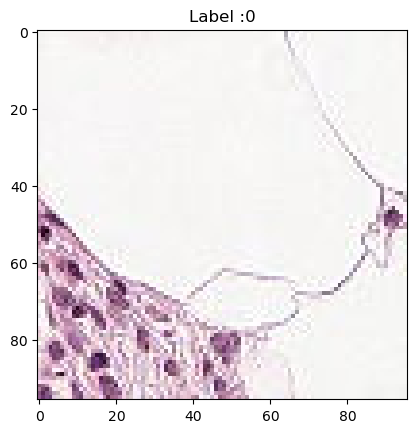

In [7]:
train_dir = '../input/histopathologic-cancer-detection/train/'
img = io.imread(train_dir+train['id'][0]+'.tif')
plt.imshow(img)
plt.title('Label :'+str(train['label'][0]))

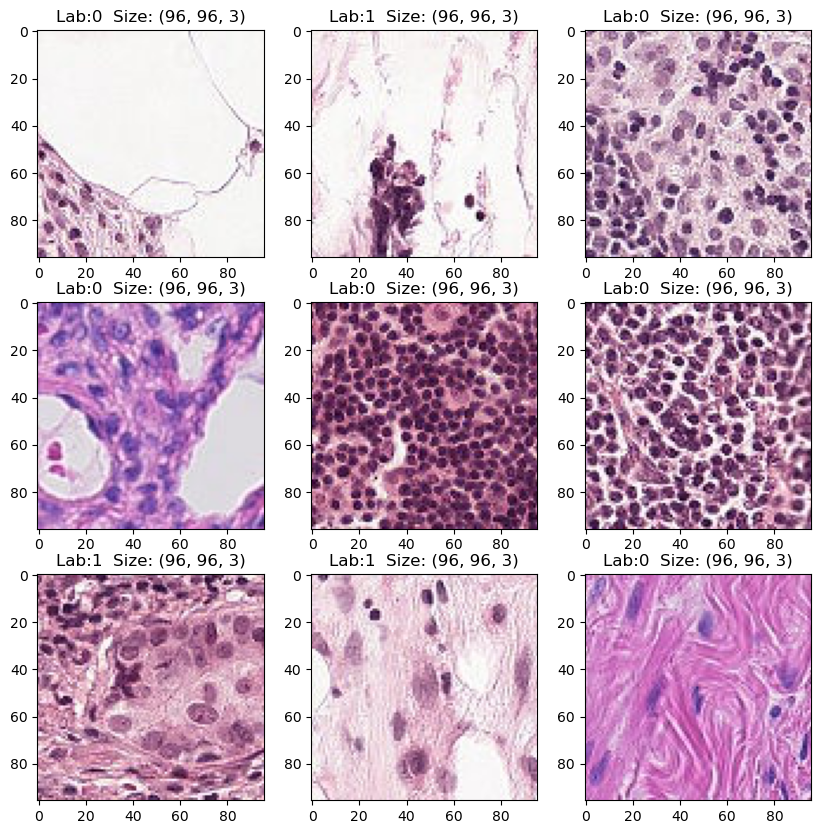

In [8]:
# Let's read a few images
train_dir = '../input/histopathologic-cancer-detection/train/'
#img = io.imread(train_dir+train['id'][0]+'.tif')
#plt.imshow(img)
#plt.title('Label :'+str(train['label'][0]))
r,c = 3 ,3

f, axes = plt.subplots(r, c,figsize = (10,10))

for i in range(r*c):
    img = io.imread(train_dir+train['id'][i]+'.tif')
    size = img.shape
    m,n = i // c, i % c
    axes[m,n].imshow(img)
    axes[m,n].set_title('Lab:'+str(train['label'][i]) + '  Size: ' +str(size))


All the images seem to have a same size of 96 x 96 x 3.

## Train - test split
We will be using only 1/10th of the data for training, validation and testing. So we will use Stratified split to maintain the class distribution. 

In [9]:
X= train['id']
y = train['label']

In [10]:
sss =StratifiedShuffleSplit(n_splits=1, random_state=100, train_size =.1)
for train_index,test_index in sss.split(X,y) :    
    X_sampled = X.loc[train_index]  # We will not be using the images in test index
    y_sampled =  y.loc[train_index]

In [11]:
X_sampled.shape

(22002,)

In [12]:
# Let's split the sampled data again to get the train and test set
sss =StratifiedShuffleSplit(n_splits=1, random_state=100, train_size =.8)
for train_index,test_index in sss.split(X_sampled,y_sampled) :    
    X,X_test = X_sampled.iloc[train_index] , X_sampled.iloc[test_index]
    y,y_test =  y_sampled.iloc[train_index],y_sampled.iloc[test_index]

In [13]:
# Let's split the training data once again to get training and validation data
sss =StratifiedShuffleSplit(n_splits=1, random_state=100, train_size =.8)
for train_index,test_index in sss.split(X,y) :    
    X_train,X_val = X.iloc[train_index] , X.iloc[test_index]
    y_train,y_val =  y.iloc[train_index],y.iloc[test_index]

Now let's use these to train and test the model

## Preparing data using Image Data Generator

In [14]:
train_df= pd.concat([X_train,y_train],axis=1)
train_df.head()

,id,label
127665,62bb83210584148c388eddd1517e3731aee479f2,0
111803,1905a567956ce8648383284b1647c5b86c859c7a,0
64257,6b65bf5ace94cd2be33c72bda8d63f759dbbd5b4,0
169021,00619f4a24fdb806f438c02b5315b653ef370f6d,0
105625,c5f130a529b963c22db24c592a1b56f2b3a3972a,0


In [15]:
# Adding filetype to the ids
train_df['id'] =train_df['id']+'.tif'

In [16]:
val_df= pd.concat([X_val,y_val],axis=1)
val_df.head()

,id,label
86471,3f82899029af1974176c5cbd715f3f7b431c423b,0
157087,7476a4e2b182c7cf7373c114d5bc2b36f6aa51bc,0
37908,84927f95de6c3f5de1531c08f90e13b2963f875f,0
189921,5df236e817922bf57e9df37495197f2a5bcfcfef,1
71673,dc3339954a755d515dcdcb01abbe4807923b5d34,1


In [17]:
# Adding filetype to the ids
val_df['id'] =val_df['id']+'.tif'

In [18]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
          rotation_range=20,
          horizontal_flip=True,
          vertical_flip=True)

In [19]:
train_data = datagen.flow_from_dataframe(
    dataframe = train_df,
    x_col='id', # filenames
    y_col='label', # labels
    directory=train_dir,
    class_mode='raw',
    batch_size=256,
    target_size=(64,64))
    

val_data=datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='id', # filenames
    y_col='label', # labels
    directory=train_dir,
    class_mode='raw',
    batch_size=256,
    target_size=(64,64))
    

Found 14080 validated image filenames.
Found 3521 validated image filenames.


## Model Building

### Model 1:  Conv 2D  without Batch Normalization

In [20]:
model = Sequential()

model.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu'))
model.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(units=256, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

batch_size = 256

model.build(input_shape=(batch_size, 64, 64, 3))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (256, 62, 62, 16)         448       
                                                                 
 conv2d_1 (Conv2D)           (256, 60, 60, 16)         2320      
                                                                 
 max_pooling2d (MaxPooling2D  (256, 30, 30, 16)        0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (256, 28, 28, 32)         4640      
                                                                 
 conv2d_3 (Conv2D)           (256, 26, 26, 32)         9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (256, 13, 13, 32)        0         
 2D)                                                    

In [21]:
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.Recall()])
history = model.fit(train_data, validation_data=val_data, epochs=30)

Epoch 1/30
55/55 [==============================] - 153s 3s/step - loss: 10.5158 - recall: 0.4918 - val_loss: 0.5757 - val_recall: 0.3843
Epoch 2/30
55/55 [==============================] - 42s 774ms/step - loss: 0.5218 - recall: 0.6698 - val_loss: 0.5163 - val_recall: 0.5856
Epoch 3/30
55/55 [==============================] - 43s 783ms/step - loss: 0.4860 - recall: 0.7168 - val_loss: 0.4673 - val_recall: 0.7511
Epoch 4/30
55/55 [==============================] - 43s 782ms/step - loss: 0.4950 - recall: 0.7073 - val_loss: 0.5258 - val_recall: 0.7405
Epoch 5/30
55/55 [==============================] - 45s 814ms/step - loss: 0.4962 - recall: 0.6965 - val_loss: 0.4845 - val_recall: 0.5806
Epoch 6/30
55/55 [==============================] - 42s 774ms/step - loss: 0.4731 - recall: 0.7059 - val_loss: 0.4559 - val_recall: 0.7700
Epoch 7/30
55/55 [==============================] - 43s 781ms/step - loss: 0.5011 - recall: 0.6775 - val_loss: 0.5093 - val_recall: 0.8226
Epoch 8/30
55/55 [==========

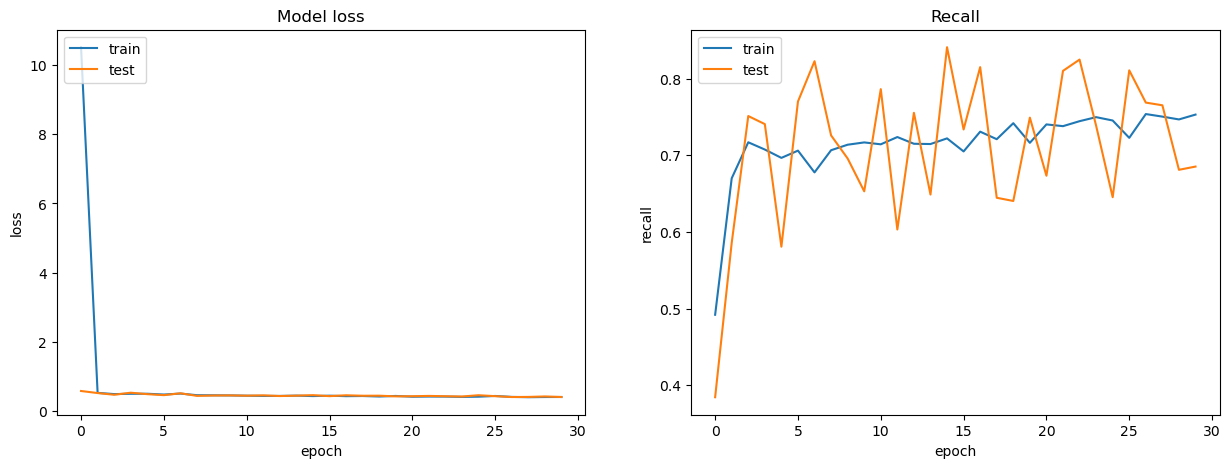

In [24]:
fig,axes = plt.subplots(1,2, figsize = (15, 5))   
# plotting loss
plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
    
# plotting Recall
plt.subplot(122)
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('Recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
    


In [36]:
history = model.fit(train_data, validation_data=val_data, epochs=30)

Epoch 1/30
55/55 [==============================] - 45s 821ms/step - loss: 0.3929 - recall: 0.7542 - val_loss: 0.4005 - val_recall: 0.7609
Epoch 2/30
55/55 [==============================] - 42s 773ms/step - loss: 0.3990 - recall: 0.7522 - val_loss: 0.4022 - val_recall: 0.8058
Epoch 3/30
55/55 [==============================] - 44s 798ms/step - loss: 0.4008 - recall: 0.7536 - val_loss: 0.4453 - val_recall: 0.5708
Epoch 4/30
55/55 [==============================] - 42s 761ms/step - loss: 0.3944 - recall: 0.7515 - val_loss: 0.4035 - val_recall: 0.7777
Epoch 5/30
55/55 [==============================] - 40s 737ms/step - loss: 0.3907 - recall: 0.7554 - val_loss: 0.4024 - val_recall: 0.6655
Epoch 6/30
55/55 [==============================] - 41s 753ms/step - loss: 0.3887 - recall: 0.7684 - val_loss: 0.4042 - val_recall: 0.8022
Epoch 7/30
55/55 [==============================] - 41s 752ms/step - loss: 0.3851 - recall: 0.7712 - val_loss: 0.4016 - val_recall: 0.6585
Epoch 8/30
55/55 [=========

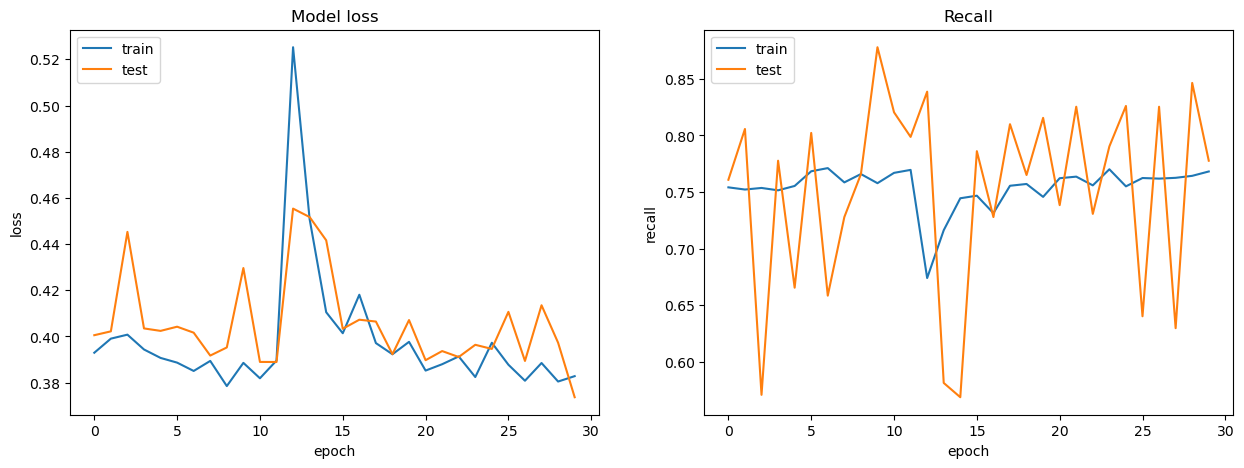

In [37]:
fig,axes = plt.subplots(1,2, figsize = (15, 5))   
# plotting loss
plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
    
# plotting Recall
plt.subplot(122)
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('Recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
    


The  training recall has stabilized wound .75 and validation recall fluctuates around .8

### Model 2:  Conv 2D  without Batch Normalization

In [25]:
model_bn = Sequential()

model_bn.add(Conv2D(filters=16, kernel_size=(3,3)))
model_bn.add(BatchNormalization())
model_bn.add(Activation('relu'))
model_bn.add(Conv2D(filters=16, kernel_size=(3,3)))
model_bn.add(BatchNormalization())
model_bn.add(Activation('relu'))
model_bn.add(MaxPool2D(pool_size=(2,2)))

model_bn.add(Conv2D(filters=32, kernel_size=(3,3)))
model_bn.add(BatchNormalization())
model_bn.add(Activation('relu'))
model_bn.add(Conv2D(filters=32, kernel_size=(3,3)))
model_bn.add(BatchNormalization())
model_bn.add(Activation('relu'))
model_bn.add(MaxPool2D(pool_size=(2,2)))

model_bn.add(Flatten())
model_bn.add(Dense(units=256, activation='relu'))
model_bn.add(Dense(units=1, activation='sigmoid'))

model_bn.build(input_shape=(256, 64, 64, 3))

model_bn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (256, 62, 62, 16)         448       
                                                                 
 batch_normalization (BatchN  (256, 62, 62, 16)        64        
 ormalization)                                                   
                                                                 
 activation (Activation)     (256, 62, 62, 16)         0         
                                                                 
 conv2d_5 (Conv2D)           (256, 60, 60, 16)         2320      
                                                                 
 batch_normalization_1 (Batc  (256, 60, 60, 16)        64        
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (256, 60, 60, 16)        

In [26]:
model_bn.compile(optimizer='Adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.Recall()])
history = model_bn.fit(train_data, validation_data=val_data, epochs=30)

Epoch 1/30
55/55 [==============================] - 51s 856ms/step - loss: 1.2260 - recall_1: 0.6723 - val_loss: 5.1896 - val_recall_1: 0.0000e+00
Epoch 2/30
55/55 [==============================] - 42s 759ms/step - loss: 0.4532 - recall_1: 0.7296 - val_loss: 1.3540 - val_recall_1: 0.0000e+00
Epoch 3/30
55/55 [==============================] - 42s 774ms/step - loss: 0.4228 - recall_1: 0.7405 - val_loss: 0.9481 - val_recall_1: 0.0049
Epoch 4/30
55/55 [==============================] - 43s 784ms/step - loss: 0.4015 - recall_1: 0.7507 - val_loss: 0.9312 - val_recall_1: 0.0449
Epoch 5/30
55/55 [==============================] - 42s 771ms/step - loss: 0.3903 - recall_1: 0.7517 - val_loss: 0.7004 - val_recall_1: 0.3233
Epoch 6/30
55/55 [==============================] - 43s 788ms/step - loss: 0.3863 - recall_1: 0.7510 - val_loss: 0.6285 - val_recall_1: 0.4201
Epoch 7/30
55/55 [==============================] - 45s 814ms/step - loss: 0.3784 - recall_1: 0.7598 - val_loss: 1.2313 - val_recall_1

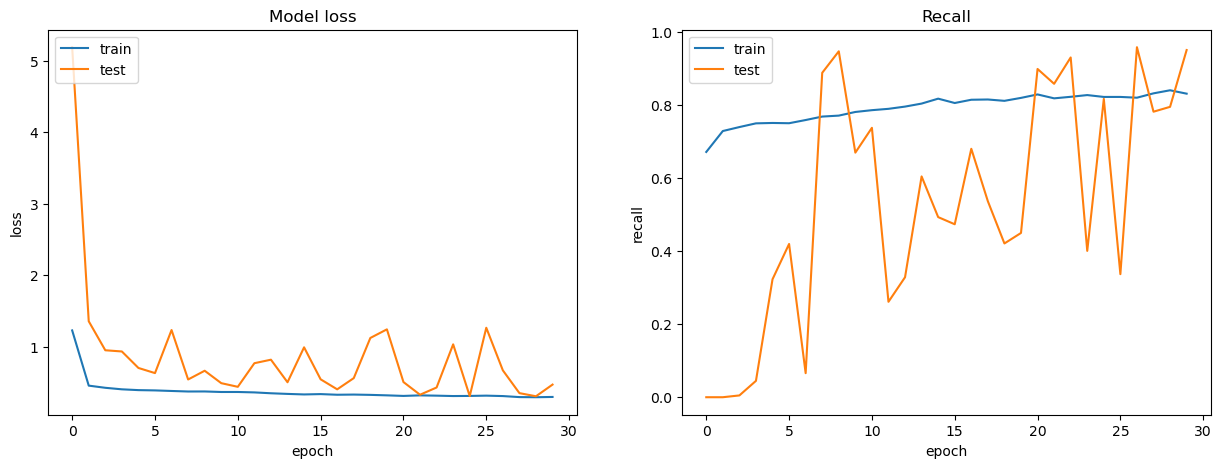

In [27]:
fig,axes = plt.subplots(1,2, figsize = (15, 5))   
# plotting loss
plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
    
# plotting Recall
plt.subplot(122)
plt.plot(history.history['recall_1'])
plt.plot(history.history['val_recall_1'])
plt.title('Recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
    


In [34]:
history = model_bn.fit(train_data, validation_data=val_data, epochs=30)

Epoch 1/30
55/55 [==============================] - 43s 787ms/step - loss: 0.2910 - recall_1: 0.8397 - val_loss: 0.4791 - val_recall_1: 0.9158
Epoch 2/30
55/55 [==============================] - 41s 747ms/step - loss: 0.2872 - recall_1: 0.8394 - val_loss: 1.8350 - val_recall_1: 0.4565
Epoch 3/30
55/55 [==============================] - 41s 747ms/step - loss: 0.2828 - recall_1: 0.8410 - val_loss: 0.7032 - val_recall_1: 0.5407
Epoch 4/30
55/55 [==============================] - 42s 768ms/step - loss: 0.2970 - recall_1: 0.8292 - val_loss: 1.9436 - val_recall_1: 0.4537
Epoch 5/30
55/55 [==============================] - 41s 753ms/step - loss: 0.2880 - recall_1: 0.8355 - val_loss: 0.3051 - val_recall_1: 0.9046
Epoch 6/30
55/55 [==============================] - 42s 771ms/step - loss: 0.2817 - recall_1: 0.8482 - val_loss: 0.5814 - val_recall_1: 0.5168
Epoch 7/30
55/55 [==============================] - 41s 755ms/step - loss: 0.2827 - recall_1: 0.8324 - val_loss: 0.5630 - val_recall_1: 0.8380

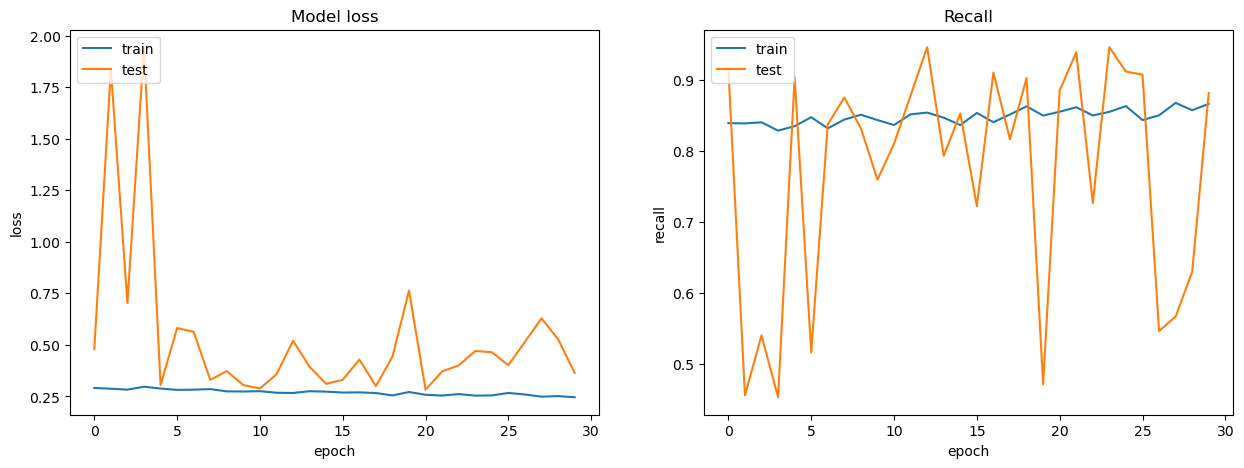

In [35]:
fig,axes = plt.subplots(1,2, figsize = (15, 5))   
# plotting loss
plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
    
# plotting Recall
plt.subplot(122)
plt.plot(history.history['recall_1'])
plt.plot(history.history['val_recall_1'])
plt.title('Recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
    


We observe that while the recall for the training data has stabilied around .85, the recall for test set is highly fluctuating and reached .88 at the end of 60 epochs

### Model 3: ResNet

In [28]:
from tensorflow.keras.applications import  ResNet50V2
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(64, 64,3))

output = base_model.layers[-1].output
output = Flatten()(output)
base_model = Model(base_model.input,output)
for layer in base_model.layers:
    layer.trainable = False
    
   
x = Conv2D(3,(3,3),
           input_shape=(64, 64,3),
           padding='same')

model_resnet = Sequential()
model_resnet.add(x)   
model_resnet.add(base_model)

model_resnet.add(Flatten())

model_resnet.add(Dense(256, activation='relu'))
model_resnet.add(BatchNormalization())
model_resnet.add(Dropout(0.25))

model_resnet.add(Dense(128, activation='relu'))
model_resnet.add(Dropout(0.25))

model_resnet.add(Dense(1, activation='sigmoid'))
model_resnet.summary()

94668760/94668760 [==============================] - 1s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 64, 64, 3)         84        
                                                                 
 model (Functional)          (None, 8192)              23564800  
                                                                 
 flatten_3 (Flatten)         (None, 8192)              0         
                                                                 
 dense_4 (Dense)             (None, 256)               2097408   
                                                                 
 batch_normalization_4 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dropout (Dropout)           (None, 256)               

In [29]:
model_resnet.compile(optimizer='Adam', loss='binary_crossentropy',metrics=[tf.keras.metrics.Recall()])
history = model_resnet.fit(train_data, validation_data=val_data, epochs=30)

Epoch 1/30
55/55 [==============================] - 52s 833ms/step - loss: 0.5326 - recall_2: 0.6795 - val_loss: 2.6692 - val_recall_2: 0.0000e+00
Epoch 2/30
55/55 [==============================] - 44s 806ms/step - loss: 0.4884 - recall_2: 0.7002 - val_loss: 1.3615 - val_recall_2: 0.0126
Epoch 3/30
55/55 [==============================] - 45s 813ms/step - loss: 0.4685 - recall_2: 0.6900 - val_loss: 1.2434 - val_recall_2: 0.0309
Epoch 4/30
55/55 [==============================] - 45s 825ms/step - loss: 0.4746 - recall_2: 0.6933 - val_loss: 0.7113 - val_recall_2: 0.1473
Epoch 5/30
55/55 [==============================] - 45s 813ms/step - loss: 0.4597 - recall_2: 0.7102 - val_loss: 0.7077 - val_recall_2: 0.1985
Epoch 6/30
55/55 [==============================] - 44s 807ms/step - loss: 0.4589 - recall_2: 0.6949 - val_loss: 0.4740 - val_recall_2: 0.5891
Epoch 7/30
55/55 [==============================] - 45s 806ms/step - loss: 0.4537 - recall_2: 0.7017 - val_loss: 0.4941 - val_recall_2: 0.

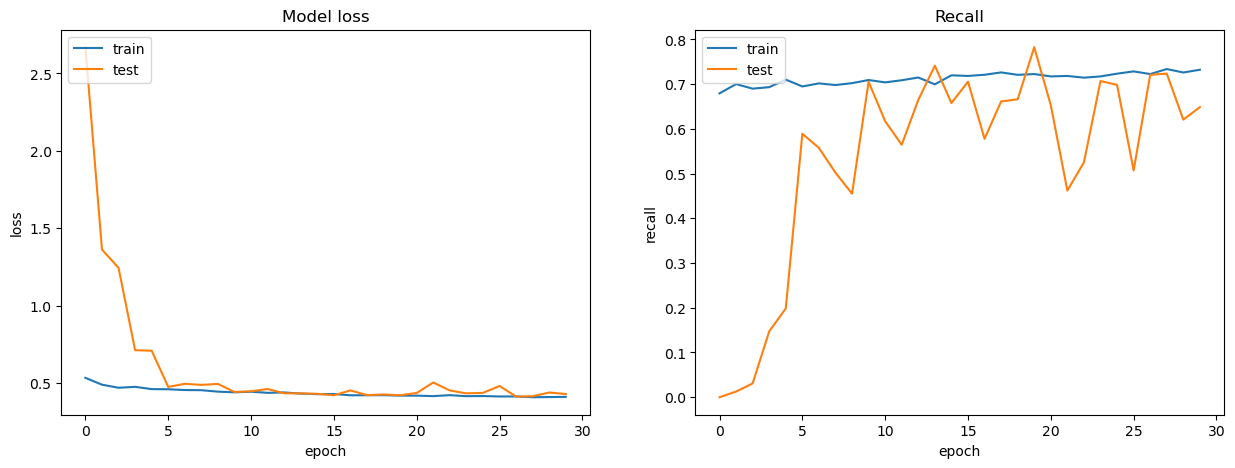

In [31]:
fig,axes = plt.subplots(1,2, figsize = (15, 5))   
# plotting loss
plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
    
# plotting Recall
plt.subplot(122)
plt.plot(history.history['recall_2'])
plt.plot(history.history['val_recall_2'])
plt.title('Recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
    


In [32]:
history = model_resnet.fit(train_data, validation_data=val_data, epochs=30)

Epoch 1/30
55/55 [==============================] - 45s 818ms/step - loss: 0.4087 - recall_2: 0.7244 - val_loss: 0.4064 - val_recall_2: 0.7370
Epoch 2/30
55/55 [==============================] - 44s 801ms/step - loss: 0.4055 - recall_2: 0.7273 - val_loss: 0.4195 - val_recall_2: 0.6459
Epoch 3/30
55/55 [==============================] - 43s 790ms/step - loss: 0.4111 - recall_2: 0.7230 - val_loss: 0.4267 - val_recall_2: 0.7188
Epoch 4/30
55/55 [==============================] - 43s 786ms/step - loss: 0.4064 - recall_2: 0.7242 - val_loss: 0.4086 - val_recall_2: 0.7244
Epoch 5/30
55/55 [==============================] - 43s 789ms/step - loss: 0.4022 - recall_2: 0.7338 - val_loss: 0.4079 - val_recall_2: 0.7125
Epoch 6/30
55/55 [==============================] - 43s 784ms/step - loss: 0.4010 - recall_2: 0.7345 - val_loss: 0.4103 - val_recall_2: 0.7328
Epoch 7/30
55/55 [==============================] - 44s 793ms/step - loss: 0.4021 - recall_2: 0.7240 - val_loss: 0.4223 - val_recall_2: 0.7097

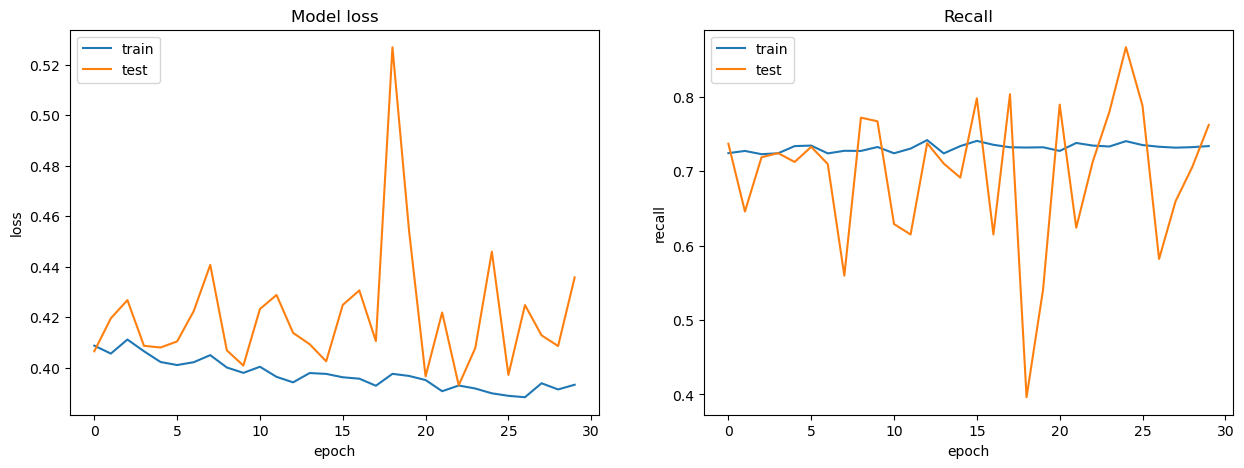

In [33]:
fig,axes = plt.subplots(1,2, figsize = (15, 5))   
# plotting loss
plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
    
# plotting Recall
plt.subplot(122)
plt.plot(history.history['recall_2'])
plt.plot(history.history['val_recall_2'])
plt.title('Recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
    


We observe that while the recall for the training data is around  .73 and the recall for test set is  fluctuating and reached .76 at the end of 60 epochs

## Evaluating on the test set

We will evaluate the model 2 - CNN + batch normalization on testing set and use it for prediction

In [38]:
test_df= pd.concat([X_test,y_test],axis=1)
test_df.head()

,id,label
149076,181409b7bb8f5789ea549e06ad318dcd09a4e54a,0
56868,7fdcee7ea777c9af2964cfcf967ddd48e95e84bf,0
24180,3407df1484911c3dffab3eb7ac5e10c0ce3b3e22,1
191670,9a62e2828a25f1a853ecba61289165a293a54738,0
38048,5ae9980c5fd6fbe0d9c3b70a6a92c725828ff7c6,0


In [39]:
test_df['id'] =test_df['id']+'.tif'

In [40]:
testgenerator = ImageDataGenerator()

test_data = testgenerator.flow_from_dataframe(
        dataframe = test_df,
        x_col='id',
        y_col='label',
        directory=train_dir,
        class_mode='raw',
        batch_size=256,
        target_size=(64,64))


Found 4401 validated image filenames.


In [46]:
 # predict with the model
result = model_bn.evaluate(test_data)
print("Recall for test set", round(result[1],4))
    

18/18 [==============================] - 6s 310ms/step - loss: 0.4232 - recall_1: 0.7385
Recall for test set 0.7385


The recall for the model is .74 which is much lower than the training results.

In [48]:
y_pred = model_bn.predict(test_data)

18/18 [==============================] - 6s 301ms/step


In [52]:
y_pred_test =  [0 if x<0.5 else 1 for x in y_pred]


In [53]:
class_report = classification_report(y_test,y_pred_test)
print(class_report)

              precision    recall  f1-score   support

           0       0.59      0.64      0.62      2619
           1       0.40      0.36      0.38      1782

    accuracy                           0.53      4401
   macro avg       0.50      0.50      0.50      4401
weighted avg       0.52      0.53      0.52      4401





## Prediction
Let's predict on random images

1/1 [==============================] - 0s 19ms/step


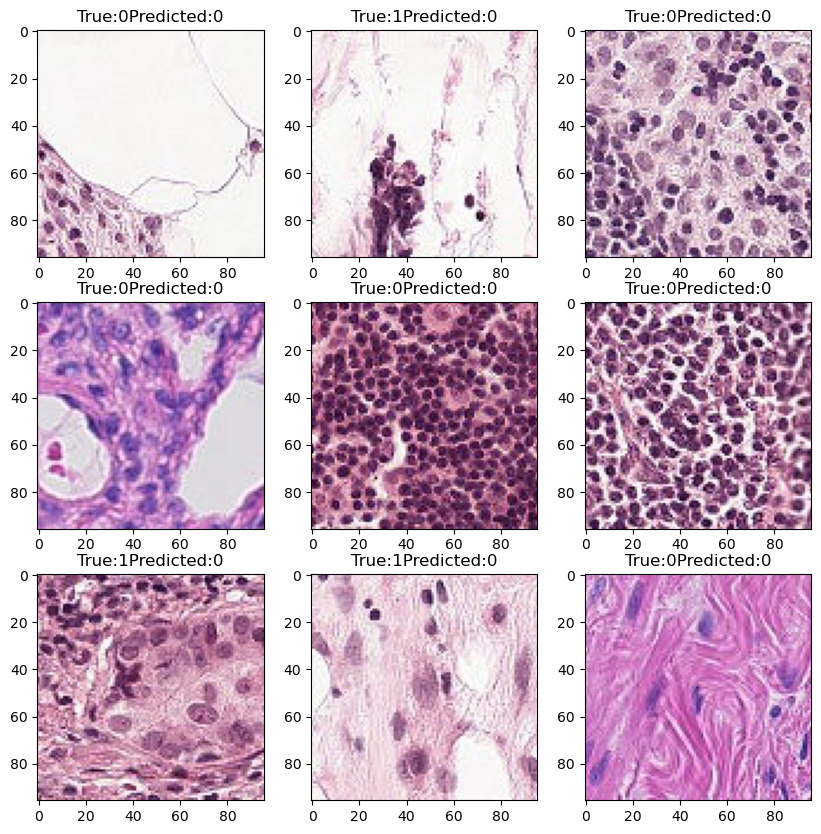

In [56]:
from skimage.transform import resize
r,c  = 3,3
f, axes = plt.subplots(r, c,figsize = (10,10))

for i in range(r*c):
    image = io.imread(train_dir+train['id'][i]+'.tif')
    img = resize(image,(64,64))
    img= np.expand_dims(img, axis=0)
    x = model_bn.predict(img)
    pred=1
    if x < 0.5:
        pred=0
     
   
    m,n = i // c, i % c
    axes[m,n].imshow(image)
    axes[m,n].set_title('True:'+str(train['label'][i])+'Predicted:'+str( pred))


We observe that cancerous cells are not detected and hence model has to be fine tuned.